# Money_Robot Noteboook

This notebook provides a way to get data for the purposes of predicting buy and sell signals through DataRobot. The notebook is designed to get data for one stock at a time, engineer buy/ sell signals for that stock, and visualize these buy and sell signals on a useful graph.

Please install dependencies using the provided requirements.txt file.

### Import dependencies

In [74]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import matplotlib.pyplot as plt

### Get stock data

Use yfinance to get data for an individual stock - select a historical timeframe. 

This is where we create the settings for our our target variable. We do this with two things: 

- A shift period
- A quantile within the probability distribution 

So for example, we could get a buy signal where we are predicting whether the stock increased 1) 3 days into the future, and whether the stock increased by a 2) 70th percentile move. This info would then be reflected in the "today" value as a "1", a buy signal, or a "0", a sell signal. The buy or sell signal is, in essence, telling you if it would have been smart to buy for a given day provided what happens in the future. 

In [75]:
stock = 'SPY' #Select the stock you would like to get data for
shift_periods = 5
move_quantile = 0.82



print('\nGetting stock data for {}...'.format(stock))
stock_dataframe = yf.Ticker(stock)
# stock_dataframe = stock_dataframe.history(period='10y')
stock_dataframe = stock_dataframe.history(period='max') #Select the timeframe (1y, 5y, 10y, 20y, max)
stock_dataframe = stock_dataframe.reset_index()
stock_dataframe['Date'] = stock_dataframe['Date'].astype(str)
stock_dataframe = stock_dataframe.reset_index(drop=True)
stock_dataframe['Ticker'] = stock
print('Loaded stock data into memory.')

stock_dataframe.head(10) #Show stock dataframe


Getting stock data for SPY...
Loaded stock data into memory.


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,1993-01-29,25.566163,25.566163,25.438969,25.547993,1003200,0.0,0,SPY
1,1993-02-01,25.566143,25.729679,25.566143,25.729679,480500,0.0,0,SPY
2,1993-02-02,25.711520,25.802373,25.657008,25.784203,201300,0.0,0,SPY
3,1993-02-03,25.820532,26.074922,25.802362,26.056751,529400,0.0,0,SPY
4,1993-02-04,26.147614,26.220297,25.856883,26.165785,531500,0.0,0,SPY
5,1993-02-05,26.147608,26.202120,26.002242,26.147608,492100,0.0,0,SPY
6,1993-02-08,26.147608,26.238461,26.111266,26.147608,596100,0.0,0,SPY
7,1993-02-09,26.056775,26.056775,25.911409,25.965921,122100,0.0,0,SPY
8,1993-02-10,25.965898,26.020410,25.893215,26.002239,379600,0.0,0,SPY
9,1993-02-11,26.038577,26.238455,26.038577,26.129431,19500,0.0,0,SPY


### Engineer the Target



In [76]:

print('\nCreating target variable for {}...'.format(stock))

#Engineer the percent change over the shift period 
stock_dataframe['later_value'] = stock_dataframe['Close'].shift(periods=-shift_periods) #What was the value, lets say, 3 days from now? 
stock_dataframe['percent_difference'] = ((stock_dataframe['later_value'] - stock_dataframe['Close']) / stock_dataframe['Close']) #What percent did the stock go up or down 

stock_dataframe.head(10) #Show the dataframe and help understand what this looks like


Creating target variable for SPY...


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,later_value,percent_difference
0,1993-01-29,25.566163,25.566163,25.438969,25.547993,1003200,0.0,0,SPY,26.147608,0.023470
1,1993-02-01,25.566143,25.729679,25.566143,25.729679,480500,0.0,0,SPY,26.147608,0.016243
2,1993-02-02,25.711520,25.802373,25.657008,25.784203,201300,0.0,0,SPY,25.965921,0.007048
3,1993-02-03,25.820532,26.074922,25.802362,26.056751,529400,0.0,0,SPY,26.002239,-0.002092
4,1993-02-04,26.147614,26.220297,25.856883,26.165785,531500,0.0,0,SPY,26.129431,-0.001389
5,1993-02-05,26.147608,26.202120,26.002242,26.147608,492100,0.0,0,SPY,25.929552,-0.008339
6,1993-02-08,26.147608,26.238461,26.111266,26.147608,596100,0.0,0,SPY,25.275431,-0.033356
7,1993-02-09,26.056775,26.056775,25.911409,25.965921,122100,0.0,0,SPY,25.257254,-0.027292
8,1993-02-10,25.965898,26.020410,25.893215,26.002239,379600,0.0,0,SPY,25.239073,-0.029350
9,1993-02-11,26.038577,26.238455,26.038577,26.129431,19500,0.0,0,SPY,25.329920,-0.030598


In [77]:

#If the change is over or under the threshold, label it a 1 - otherwise label it a 0
move_percentage = stock_dataframe['percent_difference'].quantile(move_quantile)
stock_dataframe.loc[stock_dataframe['percent_difference'] >= move_percentage, 'TARGET'] = 1
stock_dataframe.loc[stock_dataframe['percent_difference'] < move_percentage, 'TARGET'] = 0
# stock_dataframe.loc[stock_dataframe['percent_difference'] <= move_percentage, 'TARGET'] = 1
# stock_dataframe.loc[stock_dataframe['percent_difference'] > move_percentage, 'TARGET'] = 0

stock_dataframe = stock_dataframe.drop(['later_value', 'percent_difference'], axis=1) #Drop unecessary columns - optionally, drop rows where the target is empty
stock_dataframe = stock_dataframe[stock_dataframe['TARGET'].notna()]
print('Created target variable')

stock_dataframe.head(10) #Show the dataframe with the target finished

Created target variable


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,TARGET
0,1993-01-29,25.566163,25.566163,25.438969,25.547993,1003200,0.0,0,SPY,1.0
1,1993-02-01,25.566143,25.729679,25.566143,25.729679,480500,0.0,0,SPY,0.0
2,1993-02-02,25.711520,25.802373,25.657008,25.784203,201300,0.0,0,SPY,0.0
3,1993-02-03,25.820532,26.074922,25.802362,26.056751,529400,0.0,0,SPY,0.0
4,1993-02-04,26.147614,26.220297,25.856883,26.165785,531500,0.0,0,SPY,0.0
5,1993-02-05,26.147608,26.202120,26.002242,26.147608,492100,0.0,0,SPY,0.0
6,1993-02-08,26.147608,26.238461,26.111266,26.147608,596100,0.0,0,SPY,0.0
7,1993-02-09,26.056775,26.056775,25.911409,25.965921,122100,0.0,0,SPY,0.0
8,1993-02-10,25.965898,26.020410,25.893215,26.002239,379600,0.0,0,SPY,0.0
9,1993-02-11,26.038577,26.238455,26.038577,26.129431,19500,0.0,0,SPY,0.0


### Show the buy signals

In this instance, we are going to show where these buy signals are on the overall graph of the stock and see if they make sense. 

In [78]:
signal_buy = []
graph_df = stock_dataframe.copy()

#Create an array with the close value where the target = 1
for i in range(len(stock_dataframe)):
    if stock_dataframe['TARGET'][i] == 1: 
        signal_buy.append(stock_dataframe['Close'][i])
    elif stock_dataframe['TARGET'][i] == 0: 
        signal_buy.append(np.nan)


graph_df['signal_price'] = signal_buy #Create a new column with this new close value 

### Plot this - get the last year and see how our buy signal looks

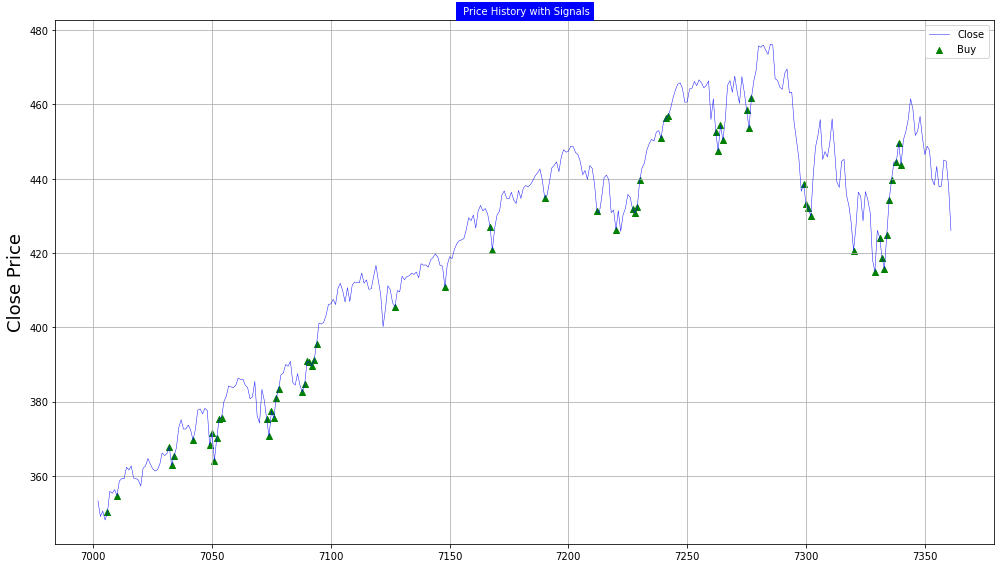

In [79]:
graph_df_shortened = graph_df.tail(360)
fig, ax = plt.subplots(figsize=(14,8))

ax.plot(graph_df_shortened['Close'] , label = 'Close' ,linewidth=0.5, color='blue', alpha = 0.9)
ax.scatter(graph_df_shortened.index , graph_df_shortened['signal_price'] , label = 'Buy' , marker = '^', color = 'green',alpha =1 )
ax.set_title(" Price History with Signals",fontsize=10, backgroundcolor='blue', color='white')
ax.set_ylabel('Close Price' , fontsize=18)
legend = ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

### Adjust! If these buy signals don't look good, change the 1) shift periods and 2) quantile above!

Iterate through various settings and find some that seem like they create good buy and sell signals that would lend themselves to a good prediction.

### Create technical indicators to add signal

Now, we're going to add the technical indicators into the dataframe in order to add some predictive signal. We're just going to add them all for now, and we're not going to mess with the settings very much. 

In [80]:
print('\nAdding technical indicators for {}...'.format(stock))
stock_dataframe = ta.add_all_ta_features(stock_dataframe, open="Open", high="High", low="Low",\
        close = "Close", volume="Volume", fillna=True)
print('Technical indicators created.')

stock_dataframe.head(10)


Adding technical indicators for SPY...


/Users/alextsourmas/Desktop/code/personal_projects/finance_linkedin_live/env/lib/python3.10/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/alextsourmas/Desktop/code/personal_projects/finance_linkedin_live/env/lib/python3.10/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/alextsourmas/Desktop/code/personal_projects/finance_linkedin_live/env/lib/python3.10/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/alextsourmas/Desktop/code/personal_projects/finance_linkedin_live/env/lib/python3.10/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64'

Technical indicators created.


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,TARGET,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,1993-01-29,25.566163,25.566163,25.438969,25.547993,1003200,0.0,0,SPY,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.547993,-80.405790,0.000000,0.000000
1,1993-02-01,25.566143,25.729679,25.566143,25.729679,480500,0.0,0,SPY,0.0,...,0.056701,0.011340,0.045360,-4.323242,-0.864648,-3.458593,25.633738,0.711157,0.708640,0.711157
2,1993-02-02,25.711520,25.802373,25.657008,25.784203,201300,0.0,0,SPY,0.0,...,0.117418,0.032556,0.084862,-10.591177,-2.809954,-7.781223,25.704209,0.211909,0.211685,0.924573
3,1993-02-03,25.820532,26.074922,25.802362,26.056751,529400,0.0,0,SPY,0.0,...,0.248337,0.075712,0.172625,-12.679267,-4.783817,-7.895450,25.872576,1.057037,1.051490,1.991384
4,1993-02-04,26.147614,26.220297,25.856883,26.165785,531500,0.0,0,SPY,0.0,...,0.381554,0.136880,0.244674,-14.306893,-6.688432,-7.618461,26.009135,0.418447,0.417574,2.418163
5,1993-02-05,26.147608,26.202120,26.002242,26.147608,492100,0.0,0,SPY,0.0,...,0.475560,0.204616,0.270943,-15.988857,-8.548517,-7.440341,26.073678,-0.069469,-0.069493,2.347015
6,1993-02-08,26.147608,26.238461,26.111266,26.147608,596100,0.0,0,SPY,0.0,...,0.543501,0.272393,0.271108,-16.091365,-10.057086,-6.034278,26.109217,0.000000,0.000000,2.347015
7,1993-02-09,26.056775,26.056775,25.911409,25.965921,122100,0.0,0,SPY,0.0,...,0.534315,0.324777,0.209538,-21.759632,-12.397596,-9.362036,26.040434,-0.694849,-0.697274,1.635857
8,1993-02-10,25.965898,26.020410,25.893215,26.002239,379600,0.0,0,SPY,0.0,...,0.532182,0.366258,0.165923,-23.262119,-14.570500,-8.691619,26.022630,0.139867,0.139770,1.778013
9,1993-02-11,26.038577,26.238455,26.038577,26.129431,19500,0.0,0,SPY,0.0,...,0.563547,0.405716,0.157831,-29.580464,-17.572493,-12.007971,26.069764,0.489156,0.487964,2.275866


### Once we like the data - save it as a CSV

It is reccomended to rename this file with some information about your settings before you arbitrarily save it, especially if you want to run multiple experiments. 

In [81]:
stock_dataframe.to_csv('stock_data.csv')